In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import sqlite3
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths
from visualizations import viz_scatterplot_correlation, viz_sideways, relative_positive_negative
from sum_stats import sum_up_attributes

In [2]:
bls_gender_race_excel_path = data_path / "bls" / "gender_race_hispanic" / "cpsaat11_gender, races, hispanic.xlsx"

gender_race_df = pd.read_excel(bls_gender_race_excel_path, skiprows = 6)

# overall labor market participation
women = gender_race_df["Unnamed: 2"][0]/100
white = gender_race_df["Unnamed: 3"][0]/100
african_american = round(gender_race_df["Unnamed: 4"][0]/100, 3)
asian = gender_race_df["Unnamed: 5"][0]/100
hispanic = gender_race_df["Unnamed: 6"][0]/100

mapping_dict = {"women": women, "white": white, "non_hispanic_white": white - hispanic,
                "african_american": african_american, "asian": asian, "hispanic": hispanic}

mapping_dict

{'women': 0.47,
 'white': 0.775,
 'non_hispanic_white': 0.595,
 'african_american': 0.123,
 'asian': 0.066,
 'hispanic': 0.18}

In [3]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

# add a column for non-hispanic white people
if "non_hispanic_white" not in df:
    df.insert(8, "non_hispanic_white", df["white"].subtract(df["hispanic"]))
    
print("The number of entries:", len(df))

The number of entries: 798


In [4]:
# adding the _summed corresponding values
for i in ["women", "white", "non_hispanic_white", "african_american", "asian", "hispanic"]:
    new_col_name = i + "_summed"
    sum_up_attributes(i, new_col_name, df)

df = df.dropna() # drop NaNs

In [12]:
df_major = df.loc[df['occ_group'] == "major"] # only majors. Redundant
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,non_hispanic_white,african_american,asian,hispanic,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.711,0.086,0.065,0.111,0.412,0.827857,0.716143,0.080143,0.065571,0.111714
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...","{""Loan officer"": [{""revid"": 492957605, ""user"":...","{""Loan officer"": 10956, ""Financial adviser"": 2...",0.548,0.780,0.677,0.105,0.086,0.103,0.496714,0.755,0.650714,0.114429,0.092143,0.104286
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...","{""Information scientist"": [{""revid"": 329917919...","{""Information scientist"": 2757, ""Software deve...",0.262,0.654,0.571,0.085,0.233,0.083,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143


In [7]:
articles_per_detailed = amount_detailed(df_all, df_major)
unique_auths, page_lengths = avg_unique_auth_page_lengths(df_major)

if "art_per_detailed" not in df_major:
    df_major.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_major:
    df_major.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_page_lengths" not in df_major:
    df_major.insert(8, "avg_page_lengths", page_lengths)
    
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_page_lengths,women,...,non_hispanic_white,african_american,asian,hispanic,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,0.409,...,0.711,0.086,0.065,0.111,0.412,0.827857,0.716143,0.080143,0.065571,0.111714
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,0.548,...,0.677,0.105,0.086,0.103,0.496714,0.755,0.650714,0.114429,0.092143,0.104286
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,0.262,...,0.571,0.085,0.233,0.083,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143


In [8]:
list(df_major.columns[-11:]) # all possible target_variables

['white',
 'non_hispanic_white',
 'african_american',
 'asian',
 'hispanic',
 'women_summed',
 'white_summed',
 'non_hispanic_white_summed',
 'african_american_summed',
 'asian_summed',
 'hispanic_summed']

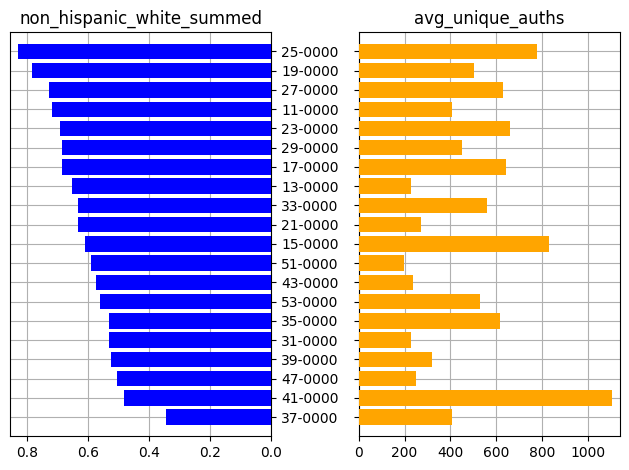

In [9]:
target_var = "non_hispanic_white_summed"

second_var = "avg_unique_auths"

viz_sideways(df_major, target_var, second_var)

Pearsons correlation: 0.168


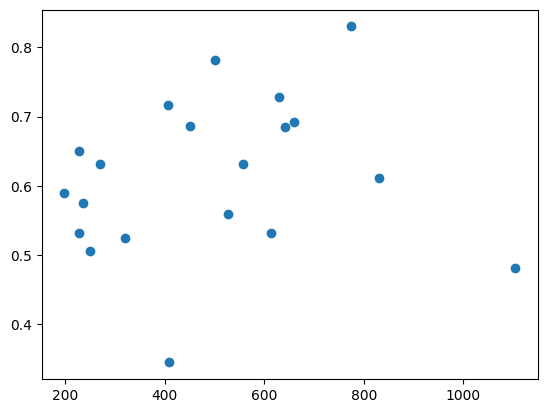

In [10]:
viz_scatterplot_correlation(df_major, target_var, second_var)

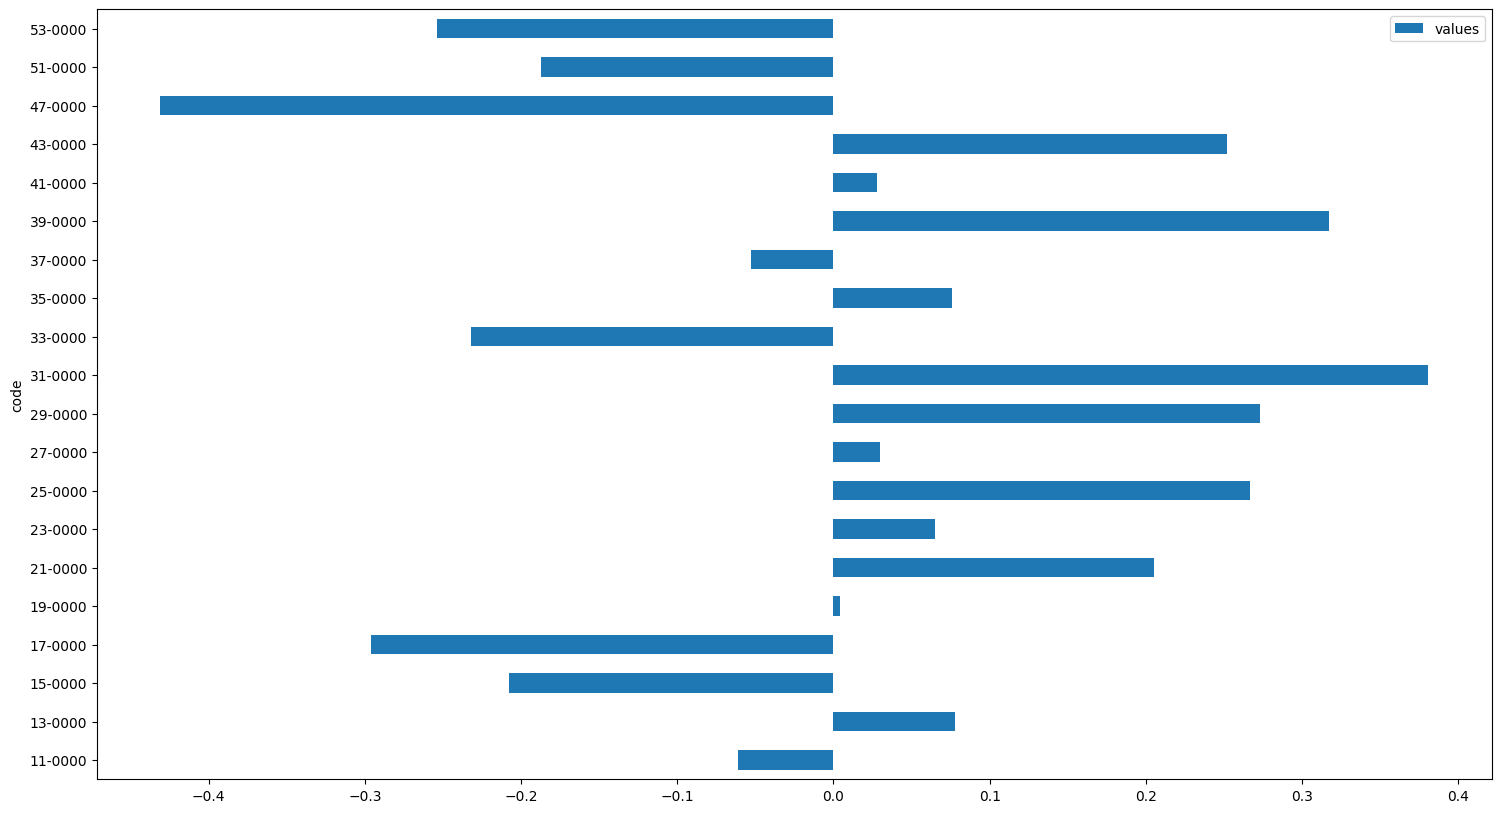

In [11]:
relative_positive_negative(df_major, "women", mapping_dict)